In [1]:
%pylab inline
import numpy as np
from sklearn import linear_model
import cv2
from math import exp
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


<h2>Initial Parameters</h2>


Import simulated images

In [2]:
R = cv2.imread('./Images/ReferenceImage.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE) 
N = cv2.imread('./Images/NewImage.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE) 
row_r, col_r = R.shape
row_n, col_n = N.shape
#vis = np.concatenate((R, N), axis=1)
#plt.imshow(vis, cmap="Greys_r")

Known image parameters (from simulation)

In [3]:
# Auxiliary functions to calculate PSFs
def gaussian(x, mu, sigma):
    return exp( -(((x-mu)/(sigma))**2)/2.0 )

def get_convolution_matrix(kernel_radius, sigma):
    # compute the kernel elements
    hkernel = [gaussian(x, kernel_radius, sigma) for x in range(2*kernel_radius+1)]
    vkernel = [x for x in hkernel]
    kernel2d = [[xh*xv for xh in hkernel] for xv in vkernel]

    # normalize the kernel elements
    kernelsum = sum([sum(row) for row in kernel2d])
    kernel2d = [[x/kernelsum for x in row] for row in kernel2d]

    return array(kernel2d)

In [4]:
# Authors specify in code that "noise must be a scalar for the entire image"
sigma_r = 100 #Std. deviation for noise in reference image
sigma_n = 100 #Std. deviation for noise in new image

# PSFs are being represented as tiles of convolution matrixes
tile_size = 15
sigma_PSF = 3.
PSF_r = get_convolution_matrix((tile_size - 1)/2, sigma_PSF) 
PSF_r = np.tile(PSF_r, (row_r/tile_size, col_r/tile_size))
PSF_n = get_convolution_matrix((tile_size - 1)/2, sigma_PSF) 
PSF_n = np.tile(PSF_n, (row_n/tile_size, col_n/tile_size))

# constant = 0.11957153
# PSF_r = constant*ones((row_r, col_r))
# PSF_n = constant*ones((row_r, col_r))

Fourier transforms

In [5]:
fourier_R = fft.fft2(R)
fourier_N = fft.fft2(N)
fourier_PSF_r = fft.fft2(PSF_r)
fourier_PSF_n = fft.fft2(PSF_n)

<h2>Finding Beta</h2>

Parameters to calculate $\beta$, the ratio of Flux Based Zero Point of the Images

In [6]:
max_iter_beta = 10000 # maximum number of iterations for the fit
beta_epsilon = 0.001 # minimum distance for convergence of the fit
epsilon = 0.001 # avoids division by zero

Fit

In [7]:
# The fit is being donde through sklearn's linear regression
# It appears this is not a robust fit, which the article calls for
def linear_fit(D_r, D_n):
    D_r_elements = D_r.flatten().reshape(-1, 1) 
    D_n_elements = D_n.flatten().reshape(-1, 1) 
    lr_model = linear_model.LinearRegression().fit(D_r_elements, D_n_elements)
    slope = lr_model.coef_[0]
    intercept = lr_model.intercept_
    return slope, intercept

In [8]:
beta = 1
gamma_prime = 0

beta_converges = False
num_iter = 0

while not beta_converges and num_iter < max_iter_beta:
    num_iter = num_iter + 1
    denom = (beta**2)*(sigma_r**2)*(fourier_PSF_n*conjugate(fourier_PSF_n)) + (sigma_n**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
    fourier_D_n = (fourier_PSF_r*fourier_N)/sqrt(denom)
    fourier_D_r = (fourier_PSF_n*fourier_R)/sqrt(denom)
    
    D_n = ifft2(fourier_D_n)
    D_r = ifft2(fourier_D_r)
    
    # Here, they select pixels which are one (really three) sigma above the image noise
    # We don't do that
    
    prev_beta = beta
    # The fit we are using ignores imaginary parts, so we fit the squares instead 
    beta, gamma_prime = linear_fit(real(D_r*conjugate(D_r)), real(D_n*conjugate(D_n)))
    if abs(beta - prev_beta) < beta_epsilon:
        beta_converges = True
gamma = gamma_prime*sqrt(sigma_n**2 + (beta**2)*(sigma_r**2))

# The article claims the number of iterations is usually small (between two and three).
# This is true for this implementation
print('Number of iterations: ' + str(num_iter))
print('Beta: ' + str(beta))
print('Gamma: ' + str(gamma))

Number of iterations: 2
Beta: [ 1.00534089]
Gamma: [ 0.12962883]


<h2>Finding S</h2>

Assignment of Flux Based Zero Points

In [9]:
# Fs are assigned as the article suggests
F_r = 1
F_n = beta

Closed formula

In [10]:
denom = (sigma_r**2)*(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n)) 
denom = denom + (sigma_n**2)*(F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
                               
fourier_S = (F_n)*(F_r**2)*conjugate(fourier_PSF_n)*(fourier_PSF_r*conjugate(fourier_PSF_r))*fourier_N
fourier_S = fourier_S - (F_r)*(F_n**2)*conjugate(fourier_PSF_r)*(fourier_PSF_n*conjugate(fourier_PSF_n))*fourier_R
fourier_S = fourier_S/denom
S = ifft2(fourier_S)

True

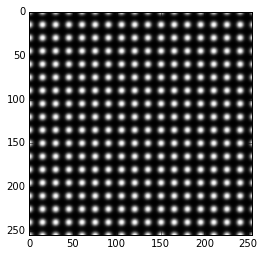

In [11]:
# We romove the imaginary parts from S by squaring it
# We also scale its histogram to 0-255
real_S = real(S*conjugate(S))
maximum_S = amax(real_S)

# We also scale its histogram to 0-255
real_S = (255/maximum_S)*real_S
maximum_S = amax(real_S)

plt.imshow(real_S, cmap="Greys_r")
cv2.imwrite('./Images/S.jpg', real_S)

Global Maxima

In [12]:
print("Maximum: " + str(maximum_S))
print("Points:")
for i in range(len(S)):
    for j in range(len(S)):
        if real_S[i][j] == maximum_S:
            print("(" + str(i) + "," + str(j) + ")")

Maximum: 255.0
Points:
(0,0)
(0,15)
(0,30)
(0,45)
(0,60)
(0,75)
(0,90)
(0,105)
(0,120)
(0,135)
(0,150)
(0,165)
(0,180)
(0,195)
(0,210)
(0,225)
(0,240)
(15,0)
(15,15)
(15,30)
(15,45)
(15,60)
(15,75)
(15,90)
(15,105)
(15,120)
(15,135)
(15,150)
(15,165)
(15,180)
(15,195)
(15,210)
(15,225)
(15,240)
(30,0)
(30,15)
(30,30)
(30,45)
(30,60)
(30,75)
(30,90)
(30,105)
(30,120)
(30,135)
(30,150)
(30,165)
(30,180)
(30,195)
(30,210)
(30,225)
(30,240)
(45,0)
(45,15)
(45,30)
(45,45)
(45,60)
(45,75)
(45,90)
(45,105)
(45,120)
(45,135)
(45,150)
(45,165)
(45,180)
(45,195)
(45,210)
(45,225)
(45,240)
(60,0)
(60,15)
(60,30)
(60,45)
(60,60)
(60,75)
(60,90)
(60,105)
(60,120)
(60,135)
(60,150)
(60,165)
(60,180)
(60,195)
(60,210)
(60,225)
(60,240)
(75,0)
(75,15)
(75,30)
(75,45)
(75,60)
(75,75)
(75,90)
(75,105)
(75,120)
(75,135)
(75,150)
(75,165)
(75,180)
(75,195)
(75,210)
(75,225)
(75,240)
(90,0)
(90,15)
(90,30)
(90,45)
(90,60)
(90,75)
(90,90)
(90,105)
(90,120)
(90,135)
(90,150)
(90,165)
(90,180)
(90,195)
(90,21

###Local Maxima

<p> We based our detection for local maxima in the image on maximum filter over the image. </p>

In [13]:
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

# Ver http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.signal.argrelextrema.html
def detect_local_maxima(arr):
    # http://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_max = (filters.maximum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_maxima = local_max - eroded_background
    return np.where(detected_maxima)  

<p> We pass the filter on the real part and the imaginary part of S and detect the local maxima in each part </p>

In [14]:
max_maks_reals = detect_local_maxima(np.real(S))
max_maks_img = detect_local_maxima(np.imag(S))

In [32]:
print max_maks_reals
print np.real(S)[max_maks_reals]

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  15,  15,  15,  15,  15,  15,  15,  15,
        15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  30,  30,  30,
        30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,
        30,  30,  45,  45,  45,  45,  45,  45,  45,  45,  45,  45,  45,
        45,  45,  45,  45,  45,  45,  45,  60,  60,  60,  60,  60,  60,
        60,  60,  60,  60,  60,  60,  60,  60,  60,  60,  60,  60,  75,
        75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,
        75,  75,  75,  75,  90,  90,  90,  90,  90,  90,  90,  90,  90,
        90,  90,  90,  90,  90,  90,  90,  90,  90, 105, 105, 105, 105,
       105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
       105, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 135, 135, 135, 135, 135, 135, 135,
       135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 1

In [16]:
print max_maks_img
print np.imag(S)[max_maks_img]

(array([  1,   1,   1, ..., 254, 254, 254]), array([ 14,  29,  44, ..., 241, 246, 254]))
[  3.33210898e-18   3.33210898e-18   3.33210898e-18 ...,   3.17261982e-18
  -3.33497806e-19   4.24503465e-18]


<p> We form and scale the image with the local maxima for the imaginary part of S</p>

In [ ]:
S_local_max_imag = np.zeros(np.imag(S).shape)
S_local_max_imag[max_maks_img] = np.imag(S)[max_maks_img]

In [29]:
# We also scale 
maximum_S_imag = np.max(S_local_max_imag)
S_local_max_imag = (255/maximum_S_imag)*S_local_max_imag
maximum_S_imag = np.max(S_local_max_imag)

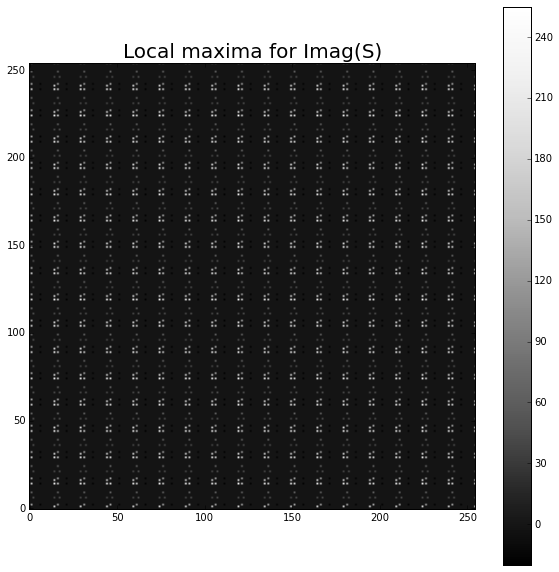

In [96]:
fig = plt.figure(figsize=(10,10))
plt.imshow(S_local_max_imag,cmap = cm.Greys_r,origin='lower')
plt.title('Local maxima for Imag(S)', fontsize=20)
plt.colorbar()
plt.savefig("./Images/local_max_imag_S.png",format = 'png')

In [18]:
plt.close(fig)

<p> We form and scale the image with the local maxima for the imaginary part of S</p>

In [ ]:
S_local_max_real = np.zeros(np.real(S).shape)
S_local_max_real[max_maks_reals] = np.real(S)[max_maks_reals]

In [33]:
# We also scale 
maximum_S_real = np.max(S_local_max_real)
S_local_max_real = (255/maximum_S_real)*S_local_max_real
maximum_S_real = np.max(S_local_max_real)

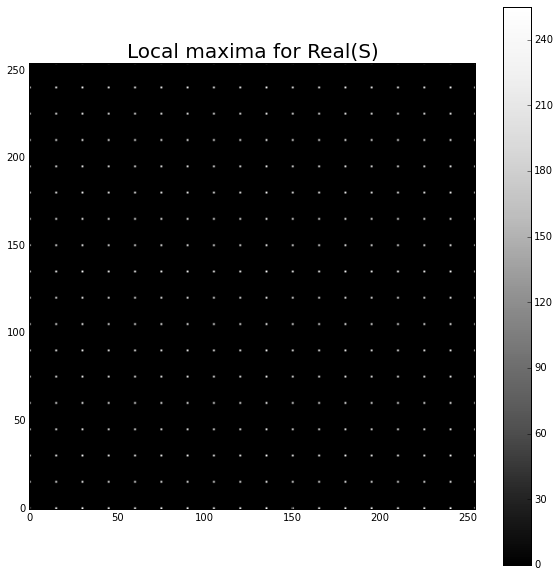

In [97]:
fig = plt.figure(figsize=(10,10))
plt.imshow(S_local_max_real,cmap = cm.Greys_r,origin='lower')
plt.title('Local maxima for Real(S)', fontsize=20)
plt.colorbar()
plt.savefig("./Images/local_max_real_S.png",format = 'png')

In [35]:
plt.close(fig)

###Histograms

<p> We visualize the histograms for the real part of S </p>

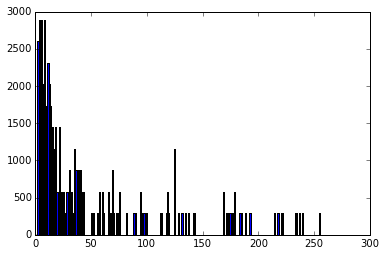

In [36]:
# Histogram of the complete S image
plt.hist(real_S.ravel(),256,[0,256]); 
plt.show()

<p> We visualize the histogram for the central tile of the PSF which seems to be the source of our troubles </p>

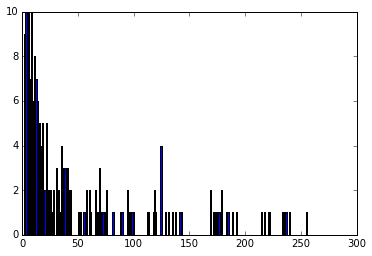

In [37]:
# Histogram of the central tile of the PSF
central_tile_bottom = row_r/2 - tile_size/2
central_tile_top = row_r/2 + tile_size/2
central_tile_left = col_r/2 - tile_size/2
central_tile_right = col_r/2 + tile_size/2
plt.hist(real_S[central_tile_bottom:central_tile_top+1, central_tile_left:central_tile_right+1].ravel(),256,[0,256]); 
plt.show()

<p> We now proceed to observe the real and imaginary parts of S</p>

In [95]:
real_part_S = np.real(S)
imag_part_S = np.imag(S)
# We also scale 
# Real part
maximum_S_real_part = np.max(real_part_S)
real_part_S = (255/maximum_S_real_part)*real_part_S
maximum_S_real_part = np.max(maximum_S_real_part)
# Imaginary part
maximum_S_imag_part = np.max(imag_part_S)
imag_part_S = (255/maximum_S_imag_part)*imag_part_S
maximum_S_imag_part = np.max(maximum_S_imag_part)

<matplotlib.colorbar.Colorbar instance at 0x7f9c921ca6c8>

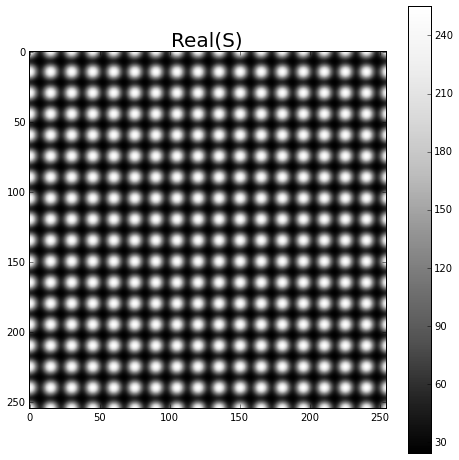

In [100]:
fig = plt.figure(figsize=(8,8))
plt.title('Real(S)', fontsize=20)
plt.imshow(real_part_S,cmap = cm.Greys_r)
plt.colorbar()

In [101]:
plt.close(fig)

<matplotlib.colorbar.Colorbar instance at 0x7f9c92041950>

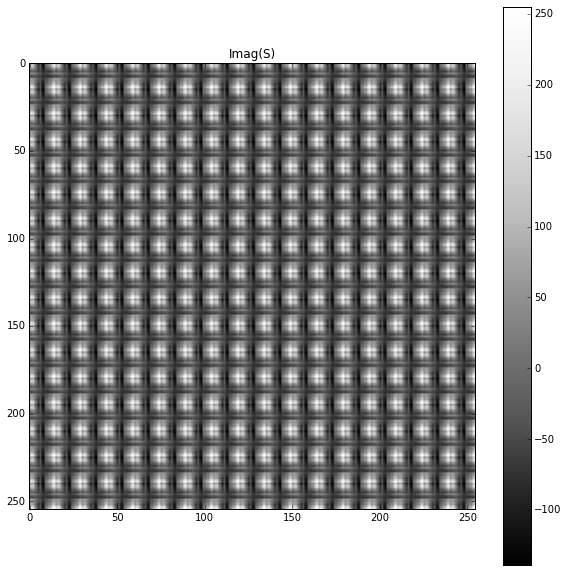

In [102]:
fig = plt.figure(figsize=(10,10))
plt.title('Imag(S)')
plt.imshow(imag_part_S,cmap = cm.Greys_r)
plt.colorbar()

In [103]:
plt.close(fig)

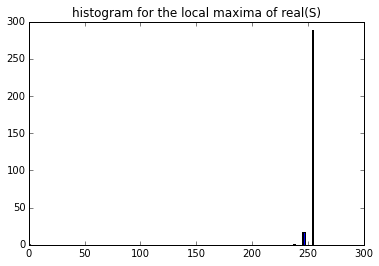

In [74]:
# Histogram of the real part of S
plt.hist(S_local_max_real.ravel(),256,[1,256])
plt.title('histogram for the local maxima of real(S)')
plt.show()

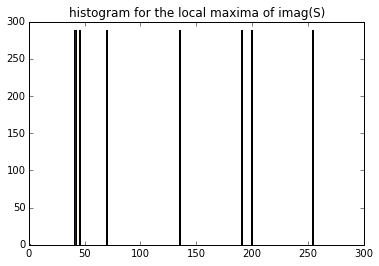

In [73]:
# Histogram of the imaginary part of S
plt.hist(S_local_max_imag.ravel(),256,[1,256]) 
plt.title('histogram for the local maxima of imag(S)')
plt.show()

<p> We observe different greyscale values. </p>
<p> We now proceed to perform a threshold on both parts, observe the results</p>

In [83]:
threshold = 250
mask_great_thresh_real = S_local_max_real > threshold
mask_great_thresh_imag = S_local_max_imag > threshold

In [84]:
# Real
S_local_max_real_thresh = np.zeros(S_local_max_real.shape)
S_local_max_real_thresh[mask_great_thresh_real] = S_local_max_real[mask_great_thresh_real]
# Imaginary
S_local_max_imag_thresh = np.zeros(S_local_max_imag.shape)
S_local_max_imag_thresh[mask_great_thresh_imag] = S_local_max_imag[mask_great_thresh_imag]

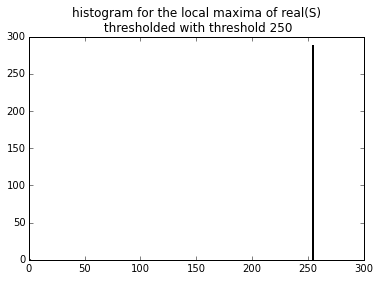

In [72]:
plt.hist(S_local_max_real_thresh.ravel(),256,[1,256])
plt.title('histogram for the local maxima of real(S) \n thresholded with threshold '+str(threshold))
plt.show()

<matplotlib.colorbar.Colorbar instance at 0x7f9c935f2cf8>

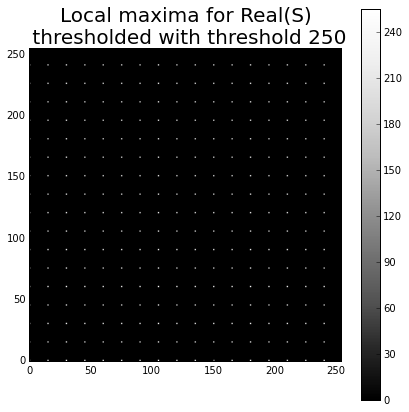

In [71]:
fig = plt.figure(figsize=(7,7))
plt.imshow(S_local_max_real_thresh,cmap = cm.Greys_r,origin='lower')
plt.title('Local maxima for Real(S) \n thresholded with threshold '+str(threshold), fontsize=20)
plt.colorbar()

In [104]:
plt.close(fig)

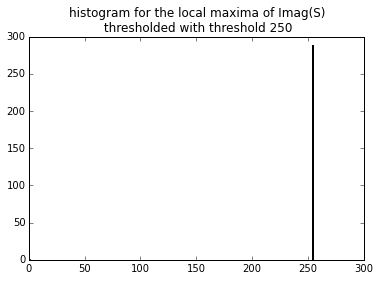

In [86]:
plt.hist(S_local_max_imag_thresh.ravel(),256,[1,256])
plt.title('histogram for the local maxima of Imag(S) \n thresholded with threshold '+str(threshold))
plt.show()

<matplotlib.colorbar.Colorbar instance at 0x7f9c93fa08c0>

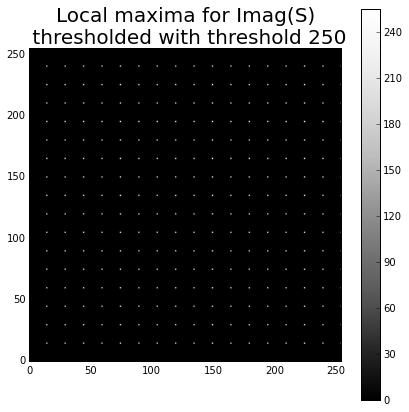

In [87]:
fig = plt.figure(figsize=(7,7))
plt.imshow(S_local_max_imag_thresh,cmap = cm.Greys_r,origin='lower')
plt.title('Local maxima for Imag(S) \n thresholded with threshold '+str(threshold), fontsize=20)
plt.colorbar()

In [105]:
plt.close(fig)

<p> The results are extremely similar. We perform a substraction to observe the differences, </p>

In [89]:
S_local_max_thresh_subs = S_local_max_imag_thresh - S_local_max_real_thresh

<matplotlib.colorbar.Colorbar instance at 0x7f9c93f27dd0>

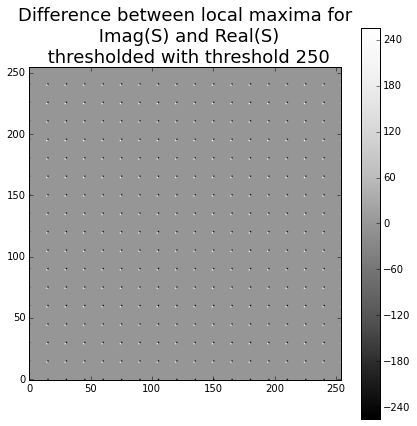

In [94]:
fig = plt.figure(figsize=(7,7))
plt.imshow(S_local_max_thresh_subs,cmap = cm.Greys_r,origin='lower')
plt.title('Difference between local maxima for \n Imag(S) and Real(S) \n thresholded with threshold '+str(threshold), fontsize=18)
plt.colorbar()

In [106]:
plt.close(fig)